# Tutorial: Fermi GBM Position History Data

Adapted from "The Position History Data" in the Fermi GBM Data Tools documentation and "Fermi GBM Position/Attitude History Data" in the Fermi Gamma-ray Data Tools documentation.

Probably the most critical auxiliary file GBM produces is the position history (POSHIST) file. The POSHIST contains, for an entire day, the spacecraft location in orbit and pointing information, sampled on a 1 second timescale. If you are just interested in triggered GRB analysis where all of the response files are already made for you, then POSHIST may not be of much interest. However, if you are using the continuous data in any way, the POSHIST is your dearest friend. You may want to know if a source is visible at a particular time (i.e. not behind the Earth), and if it is, what is the closest detector to the source. You may want to know if there are specific contributions to the background during a time interval, such as sun visibility or high geomagnetic latitude in orbit. You may want to rotate something from the equatorial frame to the Fermi inertial frame, or vice versa. Or you may want to make a pretty gif of the detector pointings over time.

In this tutorial, we will go through an example of how to use the Fermi Gamma-Ray Tools (GDT) toolkit as well as the core GDT toolkit to open, read, and plot position history data from the Fermi Gamma-ray Burst Monitor.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import gdt.missions.fermi
import gdt.core

Position history is a type of continuous data, so to download a POSHIST file, we will use the continuous data finder class `ContinuousFtp` from the GDT Fermi toolkit. We will also use the `Time` class to select the date and time that we would like our position history data to include. To read the file, we can open it with the `GbmPosHist` class. We will use **January 1st, 2017** as our example date for the rest of this tutorial.

In [26]:
from gdt.missions.fermi.gbm.finders import ContinuousFtp
from gdt.missions.fermi.time import Time
from gdt.missions.fermi.gbm.poshist import GbmPosHist
from gdt.core import data_path

# set the date/time for which you want to find poshist data for
time_0 = Time('2017-01-01')

# initialize the ContinuousFtp finder to pull data from January 1st, 2017
cont_finder = ContinuousFtp(time_0)

# download poshist data for the desired time
cont_finder.get_poshist(download_dir=data_path.joinpath('170101'))

#open and read the poshist data
filepath = data_path.joinpath('170101/glg_poshist_all_170101_v01.fit')
poshist = GbmPosHist.open(filepath)
print(poshist)

Output()

<GbmPosHist(filename="glg_poshist_all_170101_v01.fit") at 0x138f43040>


Since GBM uses the FITS format, the data files have multiple data extensions, each with metadata information in a header. There is also a primary header that contains metadata relevant to the overall file. You can access this metadata information like so:

In [3]:
poshist.headers.keys()

['PRIMARY', 'GLAST POS HIST']

In [4]:
poshist.headers['PRIMARY']

CREATOR = 'MakeDailyScpos v1.5.20 (rev: 04186289)' / Software and version creati
FILETYPE= 'GLAST POS HIST'     / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'ALL     '           / Individual detector name                       
OBSERVER= 'Meegan  '           / GLAST Burst Monitor P.I.                       
ORIGIN  = 'GIOC    '           / Name of organization making file               
DATE    = '2020-11-25T19:58:17' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
DATE-OBS= '2017-01-01T00:00:09.924' / Date of start of observation              
DATE-END= '2017-01-02T00:02:08.524' / Date of end of observation                
TIMESYS = 'TT      '           / Time system used in time keywords              
TIMEUNIT= 's       '        

The poshist object contains the spacecraft **frame**, which is the spacecraft position and orientation as a function of time, and the spacecraft **states**, which are the series of state flags as a function of time.

To see what state flags are available, we can retrieve the spacecraft states using the `get_spacecraft_states()` function:

In [5]:
# display the spacecraft states (state flags over time) from the poshist data
states = poshist.get_spacecraft_states()
print(states)

      time       sun   saa  good
---------------- ---- ----- ----
504921545.740106 True False True
504921546.740107 True False True
504921547.740107 True False True
504921548.740106 True False True
504921549.740107 True False True
504921550.740109 True False True
504921551.740107 True False True
             ...  ...   ...  ...
505008058.340076 True False True
505008059.340077 True False True
505008060.340076 True False True
505008061.340078 True False True
505008062.340075 True False True
505008063.340076 True False True
505008064.340076 True False True
Length = 86520 rows


The state flags are stored in an Astropy `TimeSeries` object, and for each sampled time, there is a flag denoting if the sun is visible, if the spacecraft is in SAA, and if the data are in a good time interval (which in this case is just the opposite of the SAA flag).

An important thing you should check is the time coverage of the POSHIST to ensure it is the file you need. The times are listed in Fermi Mission Elapsed Time (MET).

In [6]:
# view the time range covered in the particular poshist file
print('Time range: (', states[0][0], ',', states[len(states)-1][0], ')')

Time range: ( 504921545.740106 , 505008064.340076 )


Additionally, we can check the good time intervals and create a `Gti` (Good Time Intervals) object from the `time` and `good` columns:

In [27]:
from gdt.core.data_primitives import Gti

# create a Gti object of the good time interval for the data
gti = Gti.from_boolean_mask(states['time'].value, states['good'].value)
print(gti)

<Gti: 10 intervals; range (504921545.740106, 505008064.340076)>


This seems like a good time for a brief aside about MET and time conversions. Sometimes you don’t know the MET corresponding to the time you’re interested in, or you’re not sure what a given MET really means. You can easily convert MET other time formats, such a UTC time in an ISO format, and vice versa. To convert an MET time into a UTC scale and ISO format, you would call `.utc.iso`; to convert the opposite way, you would call `.fermi`.

In [7]:
# convert the start and end times for this poshist data from MET into UTC/ISO format
print('Start time:', states[0][0].utc.iso)
print('End time:', states[len(states)-1][0].utc.iso)

Start time: 2016-12-31 23:59:01.740
End time: 2017-01-02 00:00:59.340


Ok, back to the position history!

Regarding the spacecraft frame, we can retrieve it as a `SpacecraftFrame` object:

In [9]:
# display the spacecraft frames (position and orientation over time) from the poshist data
frame = poshist.get_spacecraft_frame()
print(frame)

<SpacecraftFrame: 86520 frames;
 obstime=[504921545.740106, ...]
 obsgeoloc=[(-6315714., -1549390.6, 2302684.5) m, ...]
 obsgeovel=[(1011.3916, -7244.9014, -2100.9446) m / s, ...]
 quaternion=[(x, y, z, w) [-0.21889446,  0.00818764,  0.65160715, -0.72624121], ...]>


You will notice that this frame has a location in Earth Inertial Coordinates (`obsgeoloc`), the velocity of the spacecraft with reference to the Earth Inertial Coordinate frame (`obsgeovel`), and the spacecraft orientation quaternion, each for a given time stamp (`obstime`).

Let’s say we are interested in data around a specific time, for example MET=**504975500**. We can generate an interpolated frame at the requested time, as long as it exists within the boundaries of the file.

In [28]:
# pull out one spacecraft frame at a specific time
time = Time(504975500, format='fermi')
one_frame = frame.at(time)
print(one_frame)

<SpacecraftFrame: 1 frames;
 obstime=[504975500.0]
 obsgeoloc=[(6294771.65990569, -825118.18949373, -2751704.74152787) m]
 obsgeovel=[(1531.48673123, 7317.65930685, 1296.24008645) m / s]
 quaternion=[(x, y, z, w) [ 0.20026199, -0.66690538,  0.49459807, -0.52010105]]>


We can retrieve where Fermi was in orbit at that time using the `earth_location` attribute, which is an Astropy `EarthLocation` object.

In [11]:
# latitute of Fermi at the specified time
print('Latitute:', one_frame.earth_location.lat)

# longitude of Fermi at the specified time
print('Longitude:', one_frame.earth_location.lon)

# altitude of Fermi at the specified time
print('Altitude:', one_frame.earth_location.height)

Latitute: -23d28m09.34699147s
Longitude: 26d44m11.44236177s
Altitude: 544542.2936670665 m


We might be interested to know where the Earth is (and its apparent radius) relative to Fermi, which we can find like so:

In [14]:
# show the Earth's location relative to Fermi
one_frame.geocenter.ra, one_frame.geocenter.dec

(<Longitude 172.53224953 deg>, <Latitude 23.43352709 deg>)

In [31]:
# show the apparent radius of the Earth from Fermi's location
one_frame.earth_angular_radius

<Quantity 67.1226193 deg>

It might be useful to know if the sun is visible. Perhaps you’re interested in looking for solar emission or you’re worried about noise contributions from the sun. This can be easily determined using the `sun_visible` attribute.

In [33]:
# tell if the sun is visible at the specified time
print('Sun visible =', one_frame.sun_visible)

Sun visible = True


You can also check is the sun is visible, as well as if if Fermi was in the SAA at the specified time, by pulling from the spacecraft states described above.

In [30]:
# display the spacecraft state near the specified time
# the spacecraft state tells you if the sun is visible, if Fermi is in the SAA, and if it is in a GTI at the specified time
print(states.loc[time : time+0.00001])

      time       sun   saa  good
---------------- ---- ----- ----
504975500.340079 True False True


We could be interested in a particular known source, and it would be helpful to know if it is even visible to Fermi at the time of interest. If we create an Astropy `SkyCoord` object with our source's location, we can easily determine if it was visible Fermi at the specified time using the `location_visible` function. 

In [17]:
from astropy.coordinates import SkyCoord

# the location of our source
coord = SkyCoord(324.3, -20.8, frame='icrs', unit='deg')

# tell if the above source is visible at the specified time
one_frame.location_visible(coord)

True

We might want to look at the data for the closest detector to that position. We can figure that out. Where is detector ‘n0’ pointing?

In [18]:
# display the pointing of the n0 detector at the specified time
one_frame.detectors.n0.skycoord(one_frame).icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(327.88023524, -18.18014898)]>

Luckily, that is pretty close to our source position. What’s the detector-source angle?

In [19]:
# display the angle between the n0 detector and the above source at the specified time
one_frame.detector_angle('n0', coord)

<Angle [4.27219806] deg>

Sometimes it’s useful to transform a source location of interest in equatorial coordinates to the Fermi inertial frame. You can do that by the following:

In [20]:
# transform the above source's location into the Fermi inertial frame
coord_sc_frame = coord.transform_to(one_frame)
coord_sc_frame.az, coord_sc_frame.el

(<Longitude [39.67934005] deg>, <Latitude [65.85535956] deg>)

Note that the frame transformation is in azimuth and elevation. It’s important to note that the Fermi inertial frame is defined by azimuth (0-360 deg) and elevation (-90-90 deg) or zenith (0-180 deg). Here, azimuth=0 is approximately the pointing of detector NaI 5, and increases counter-clockwise when looking down the LAT boresight. Elevation=90 (zenith=0) is defined as the LAT boresight, and elevation=-90 (zenith=180) is directly below the spacecraft.

You can also go from Fermi (azimuth, elevation) coordinates to equatorial coordinates like so:

In [21]:
# Az=0, El=90 (the Fermi LAT boresight)
sc_coord = SkyCoord(0.0, 90.0, frame=one_frame, unit='deg')
sc_coord.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    [(333.15399016, 1.73430464)]>

Note that any and all of these operations can be performed on an array of frames, even on the entire series of frames contained within the poshist file.

We can also make a sky plot for a given time. We can plot the Equatorial Frame using the `EquatorialPlot` class from the GDT Core toolkit.

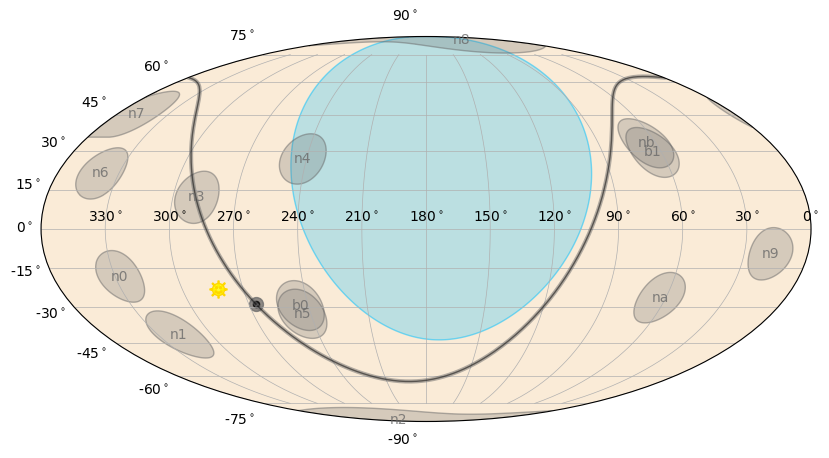

In [22]:
from gdt.core.plot.sky import EquatorialPlot

# make an equatorial frame plot of the spacecraft frame at the specified time
eqplot = EquatorialPlot()
eqplot.add_frame(one_frame)
plt.show()

The blue area in the middle of the plot is the Earth as observed by Fermi; nothing behind that is visible. The curved gray line going through the plot demarcates the Galactic Plane, and the dot is the Galactic Center. All of the gray labeled circles are the GBM detector pointings. Note these are not representative of the field-of-view (FoV) of the detectors (their FoV is virtually the whole sky). But they do allow you to visualize where the effective area of each detector is near its maximum. Finally, the yellow smiley-face is the sun.

Additionally, you can plot the Galactic Frame using the `GalacticPlot` class:

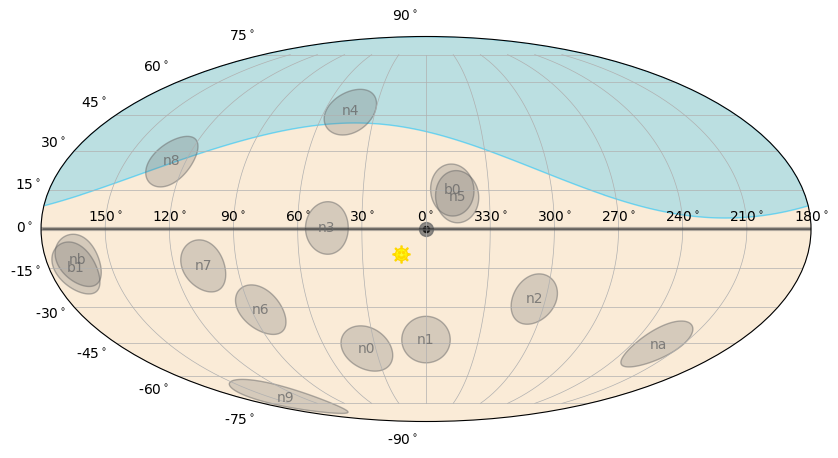

In [23]:
from gdt.core.plot.sky import GalacticPlot

# make an galactic frame plot of the spacecraft frame at the specified time
galplot = GalacticPlot()
galplot.add_frame(one_frame)
plt.show()

Or the Spacecraft Frame using the `SpacecraftPlot` class:

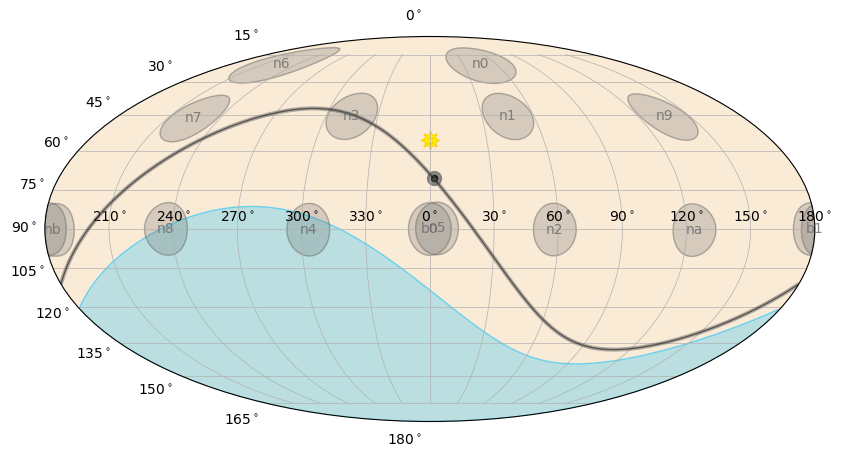

In [24]:
from gdt.core.plot.sky import SpacecraftPlot

# make an spacecraft frame plot of the spacecraft frame at the specified time
scplot = SpacecraftPlot()
scplot.add_frame(one_frame)
plt.show()

Finally, we can plot a segment of the Fermi orbit and the location of Fermi relative to the Earth at our desired time using the `FermiEarthPlot` class:

AttributeError: 'Colorbar' object has no attribute 'draw_all'

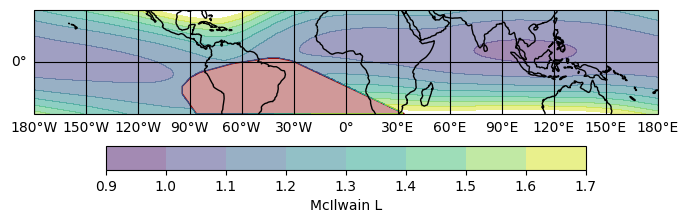

In [25]:
from gdt.missions.fermi.plot import FermiEarthPlot
from gdt.missions.fermi.gbm.saa import GbmSaa

# plot the spacecraft's location on a map of the Earth
earthplot = FermiEarthPlot(saa=GbmSaa())

# orbit segment 1000 s prior to our time of interest and 1000 s after
earthplot.add_spacecraft_frame(frame, tstart=Time(time.fermi-1000, format='fermi'), tstop=2000, trigtime=time)
earthplot.standard_title()
plt.show()

Luckily, our time of interest was just after Fermi exited the SAA (red shaded region). You can see the Fermi orbital path in gray, and the colored contours represent the McIlwain L (proxy for geomagnetic latitude). Fermi’s location relative to the McIlwain L contours is important, because higher backgrounds and local particle flux trapped in the geomagnetic field are more likely an issue towards the higher end of this scale.

Congratulations, you’ve completed the lesson on position history data!